# Preprocessing

## Imports

In [22]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [23]:
# check the current working directory
current_working_directory = os.getcwd()
print(current_working_directory)

/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project/modelo_normal


In [24]:
PATH = '/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project'

# load data
data = pd.read_csv(f'{PATH}/dataset/AEP_hourly.csv')

# Display the first few rows of the dataframe
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [25]:
# Display dataframe information
print("\nDataFrame Information:\n")
data.info()


DataFrame Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [26]:
# Display summary statistics
print("\nSummary Statistics:\n")
data.describe()


Summary Statistics:



,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


## Raw Data Visualization

1. Time Series Plot of AEW_MW

In [27]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)  # Drop rows with invalid dates
data.sort_values(by='Datetime', inplace=True)  # Sort values by date

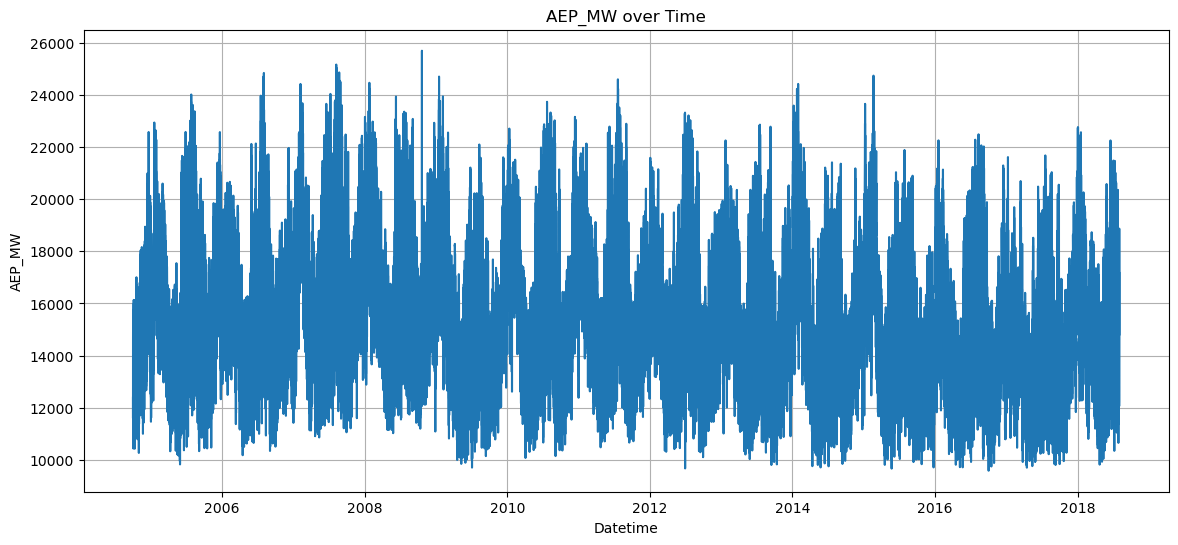

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(data['Datetime'], data['AEP_MW'])
plt.title('AEP_MW over Time')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.show()

2. Histogram of AEP_MW

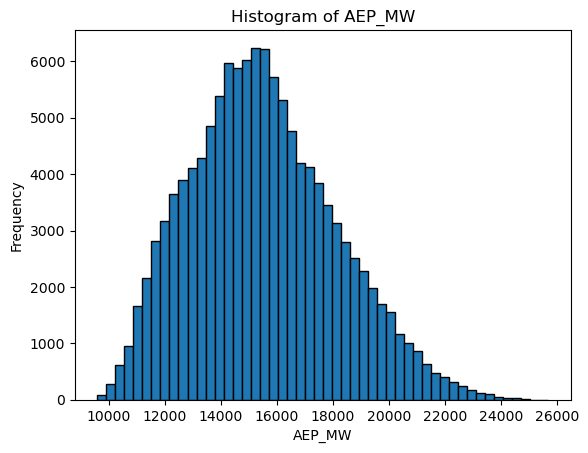

In [29]:
plt.Figure(figsize=(8, 5))
plt.hist(data['AEP_MW'], bins=50, edgecolor='black')
plt.title('Histogram of AEP_MW')
plt.xlabel('AEP_MW')
plt.ylabel('Frequency')
plt.show()

3. Box Plot of AEP_MW

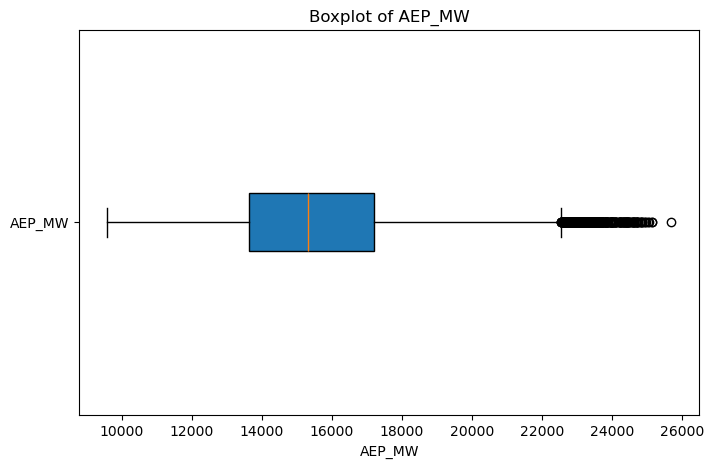

In [30]:
plt.figure(figsize=(8, 5))
plt.boxplot(data['AEP_MW'], vert=False, patch_artist=True, tick_labels=['AEP_MW'])
plt.title('Boxplot of AEP_MW')
plt.xlabel('AEP_MW')
plt.show()

## Feature Engineering

In [31]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['Datetime'].dt.date
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['dayofmonth'] = df['Datetime'].dt.day
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week

    return df

def transformations(df):
    """
    Apply cosine and sine transformations to the datetime features
    """
    df['hour_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.hour / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.dayofweek / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.dayofweek / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.month / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    return df


def lag_features(df, lags=[1], columns=['AEP_MW']):
    """
    Create time lag features
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    return df

def pipeline(data):
    """
    Feature engineering pipeline
    """
    df = data.copy()
    df = create_features(df)
    df = transformations(df)
    df = lag_features(df, lags=[1, 2, 3, 6, 12, 24, 48, 72, 168], columns=['AEP_MW'])
    df.dropna(inplace=True)
    return df

df0 = data.copy()

df = pipeline(data)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121105 entries, 2015 to 116161
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Datetime        121105 non-null  datetime64[ns]
 1   AEP_MW          121105 non-null  float64       
 2   date            121105 non-null  object        
 3   dayofweek       121105 non-null  int32         
 4   quarter         121105 non-null  int32         
 5   month           121105 non-null  int32         
 6   year            121105 non-null  int32         
 7   dayofyear       121105 non-null  int32         
 8   dayofmonth      121105 non-null  int32         
 9   weekofyear      121105 non-null  UInt32        
 10  hour_sin        121105 non-null  float64       
 11  hour_cos        121105 non-null  float64       
 12  dayofweek_sin   121105 non-null  float64       
 13  dayofweek_cos   121105 non-null  float64       
 14  month_sin       121105 non-null  float

## Visualization of cyclical features over time

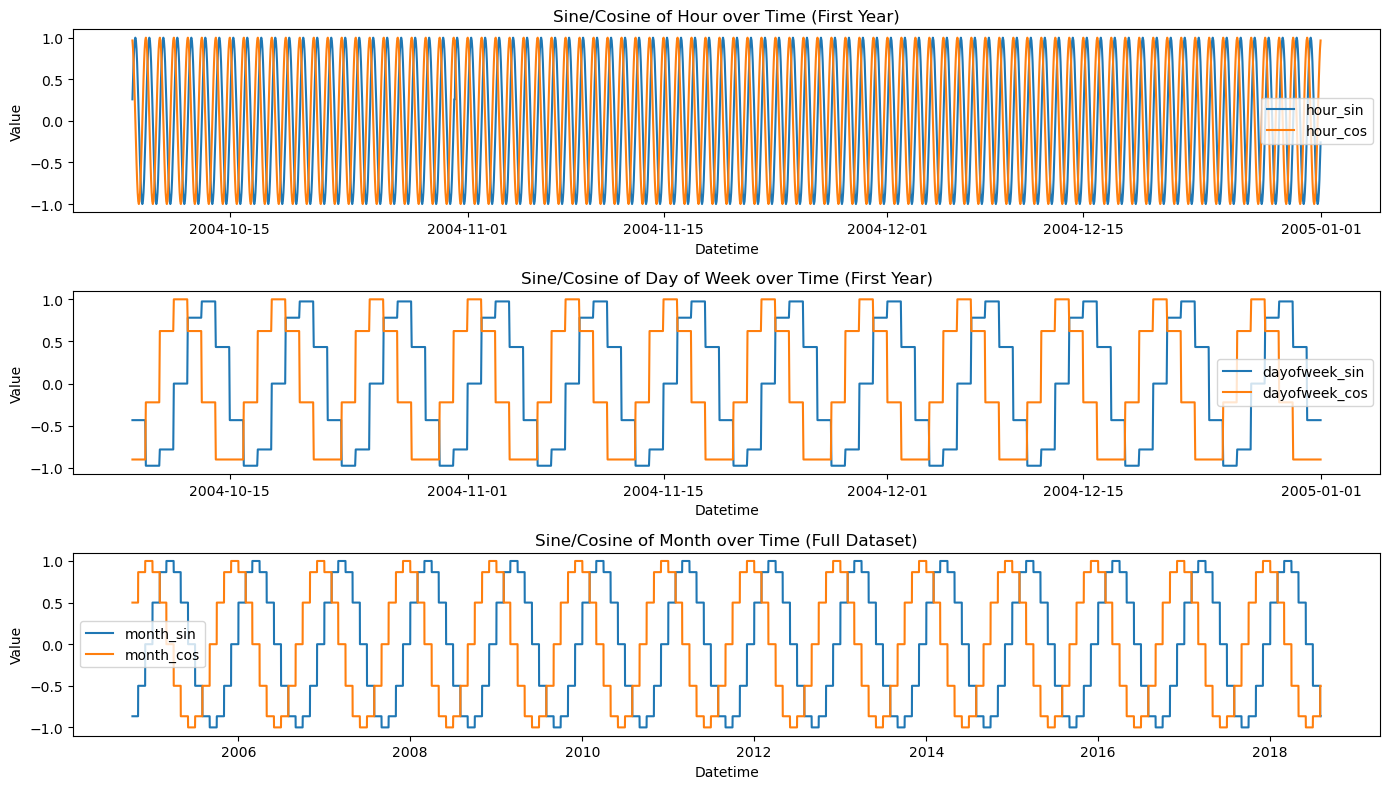

In [32]:
# Use the entire dataset for the month plot, but keep the first year for hour and dayofweek
subset_year = df[df['Datetime'].dt.year == df['Datetime'].dt.year.min()]

# Hourly df for hour and dayofweek
start_date_year = subset_year['Datetime'].min()
end_date_year = subset_year['Datetime'].max()
date_range_year = pd.date_range(start=start_date_year, end=end_date_year, freq='h')

df_hourly_year = pd.DataFrame({'Datetime': date_range_year})
df_hourly_year = pd.merge(df_hourly_year, subset_year[['Datetime', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']], on='Datetime', how='left')
df_hourly_year.ffill(inplace=True)

# Hourly df for the *entire* dataset, for the month plot
start_date_full = df['Datetime'].min()
end_date_full = df['Datetime'].max()
date_range_full = pd.date_range(start=start_date_full, end=end_date_full, freq='h')
df_hourly_full = pd.DataFrame({'Datetime': date_range_full})
df_hourly_full = pd.merge(df_hourly_full, df[['Datetime', 'month_sin', 'month_cos']], on='Datetime', how='left')
df_hourly_full.ffill(inplace=True)

# Recalculate month_sin/cos for plotting (using the full hourly data)
df_hourly_full['month'] = df_hourly_full['Datetime'].dt.month
df_hourly_full['month_sin'] = np.sin(2 * np.pi * df_hourly_full['month'] / 12)
df_hourly_full['month_cos'] = np.cos(2 * np.pi * df_hourly_full['month'] / 12)


plt.figure(figsize=(14, 8))

# Hour (first year, hourly)
plt.subplot(3, 1, 1)
plt.plot(df_hourly_year['Datetime'], df_hourly_year['hour_sin'], label='hour_sin')
plt.plot(df_hourly_year['Datetime'], df_hourly_year['hour_cos'], label='hour_cos')
plt.title('Sine/Cosine of Hour over Time (First Year)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()

# Day of Week (first year, hourly)
plt.subplot(3, 1, 2)
plt.plot(df_hourly_year['Datetime'], df_hourly_year['dayofweek_sin'], label='dayofweek_sin')
plt.plot(df_hourly_year['Datetime'], df_hourly_year['dayofweek_cos'], label='dayofweek_cos')
plt.title('Sine/Cosine of Day of Week over Time (First Year)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()

# Month (full dataset, hourly)
plt.subplot(3, 1, 3)
plt.plot(df_hourly_full['Datetime'], df_hourly_full['month_sin'], label='month_sin')
plt.plot(df_hourly_full['Datetime'], df_hourly_full['month_cos'], label='month_cos')
plt.title('Sine/Cosine of Month over Time (Full Dataset)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## Correlation Heatmap

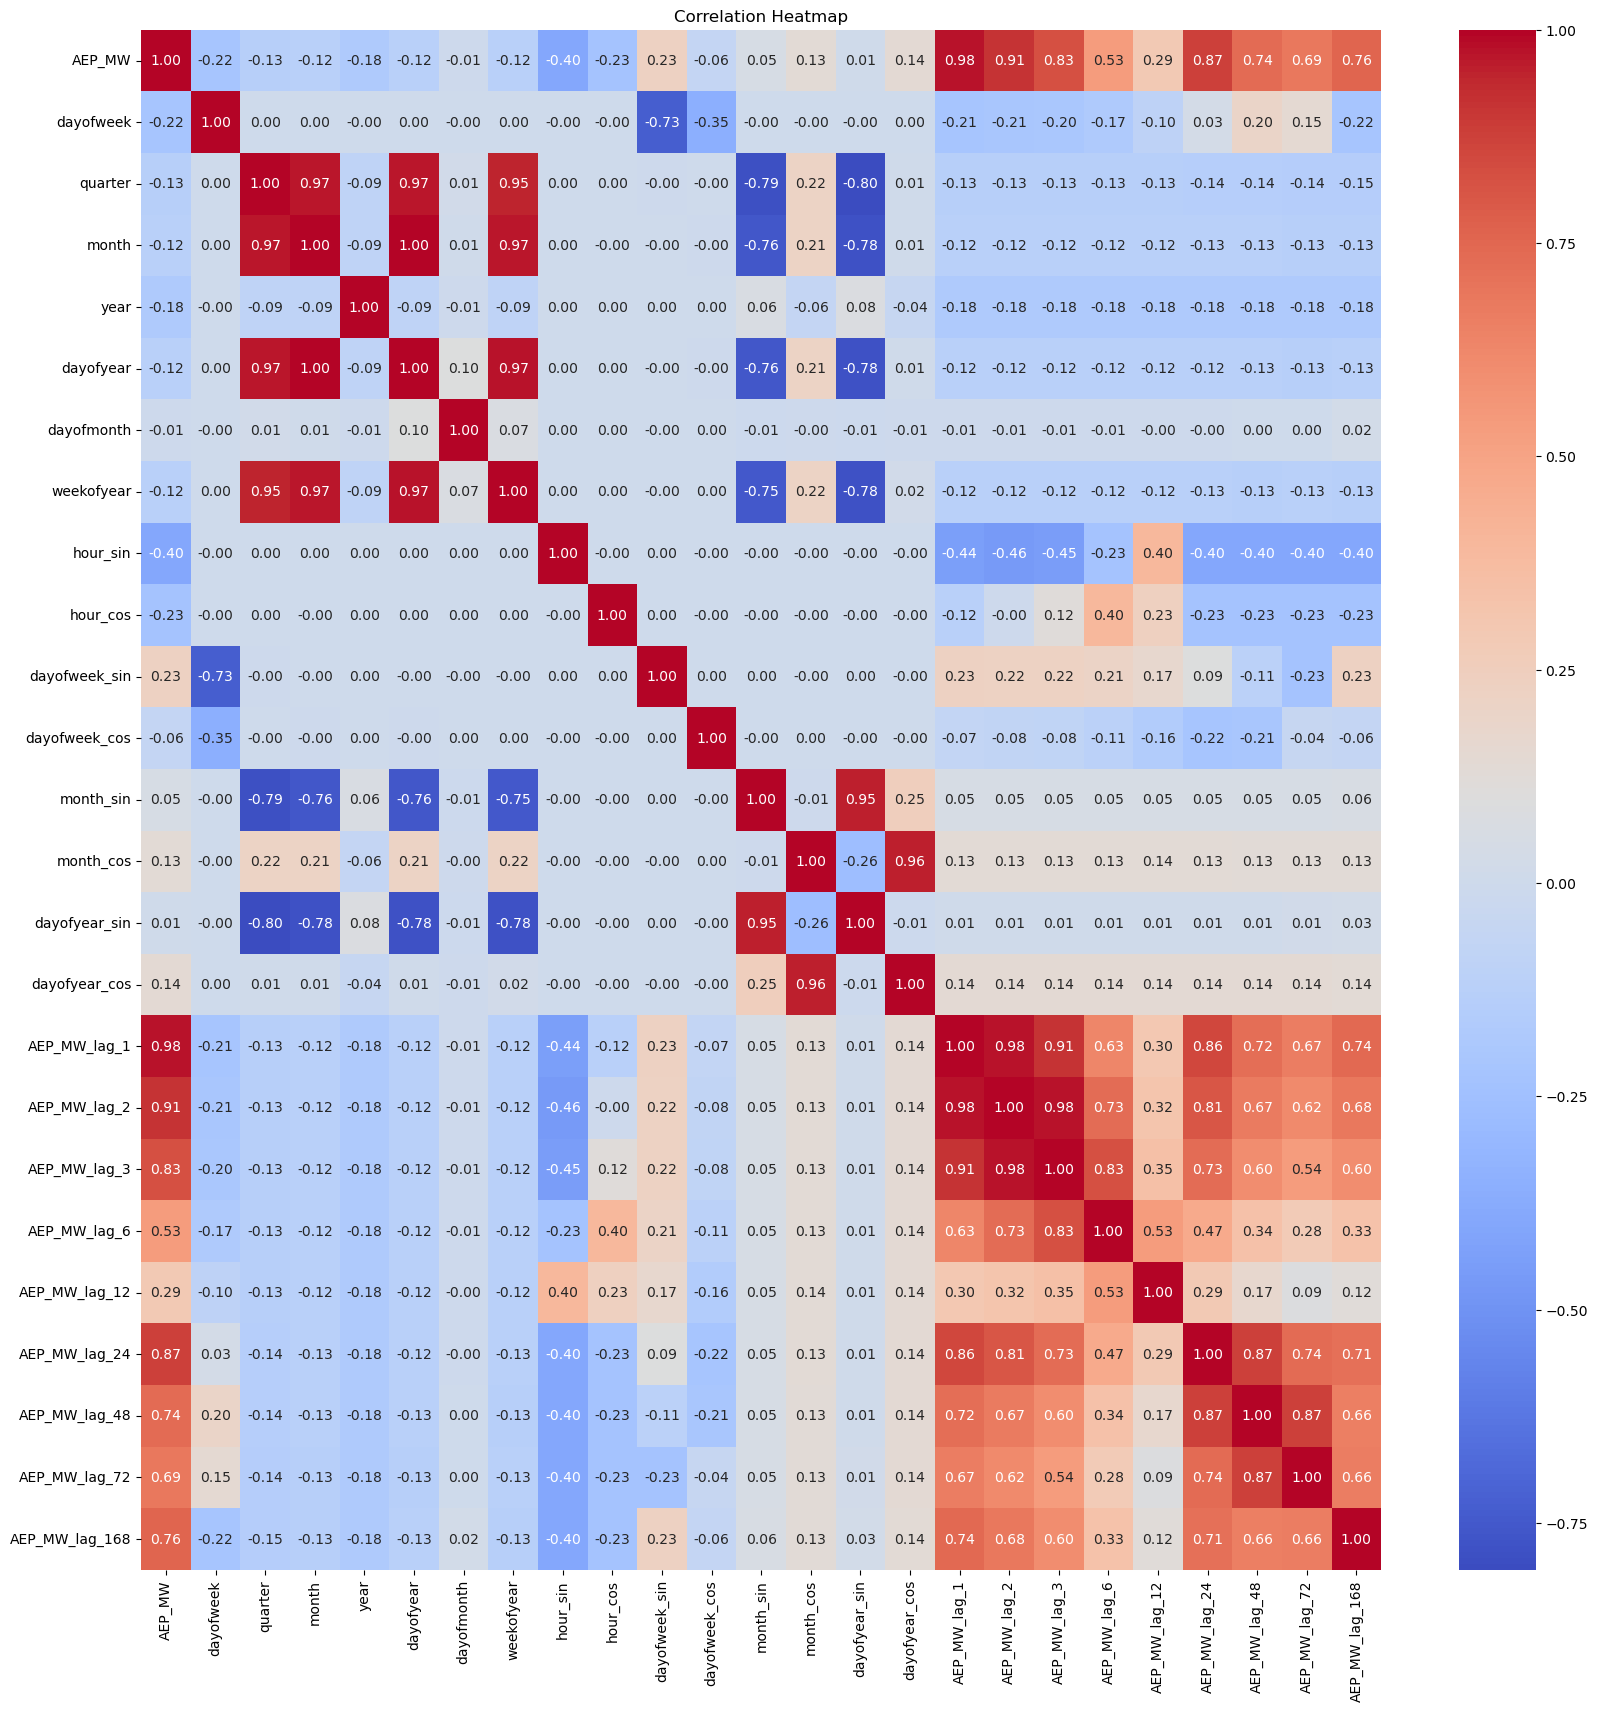

In [33]:
# Correlation heatmap
plt.figure(figsize=(20, 20))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Correlation between the target variable and the features


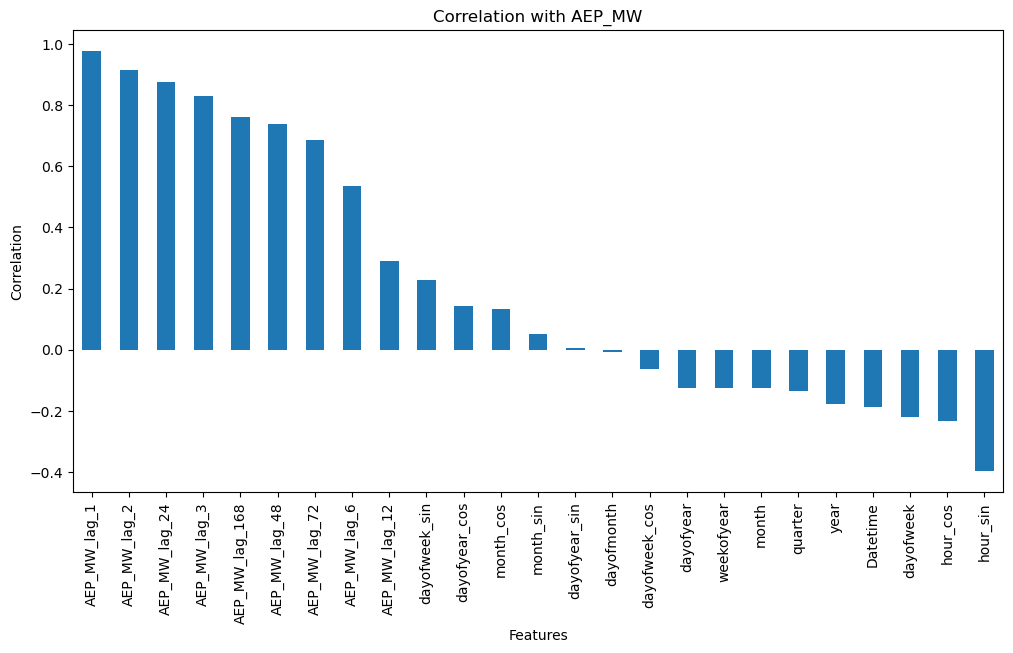

In [34]:
# visualize the correlation between the target variable and the features
plt.figure(figsize=(12, 6))
df_corr = df.drop(columns=['date']).corr()
df_corr = df_corr['AEP_MW'].sort_values(ascending=False)[1:]
df_corr.plot(kind='bar')
plt.title('Correlation with AEP_MW')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

## Lagged features visualization

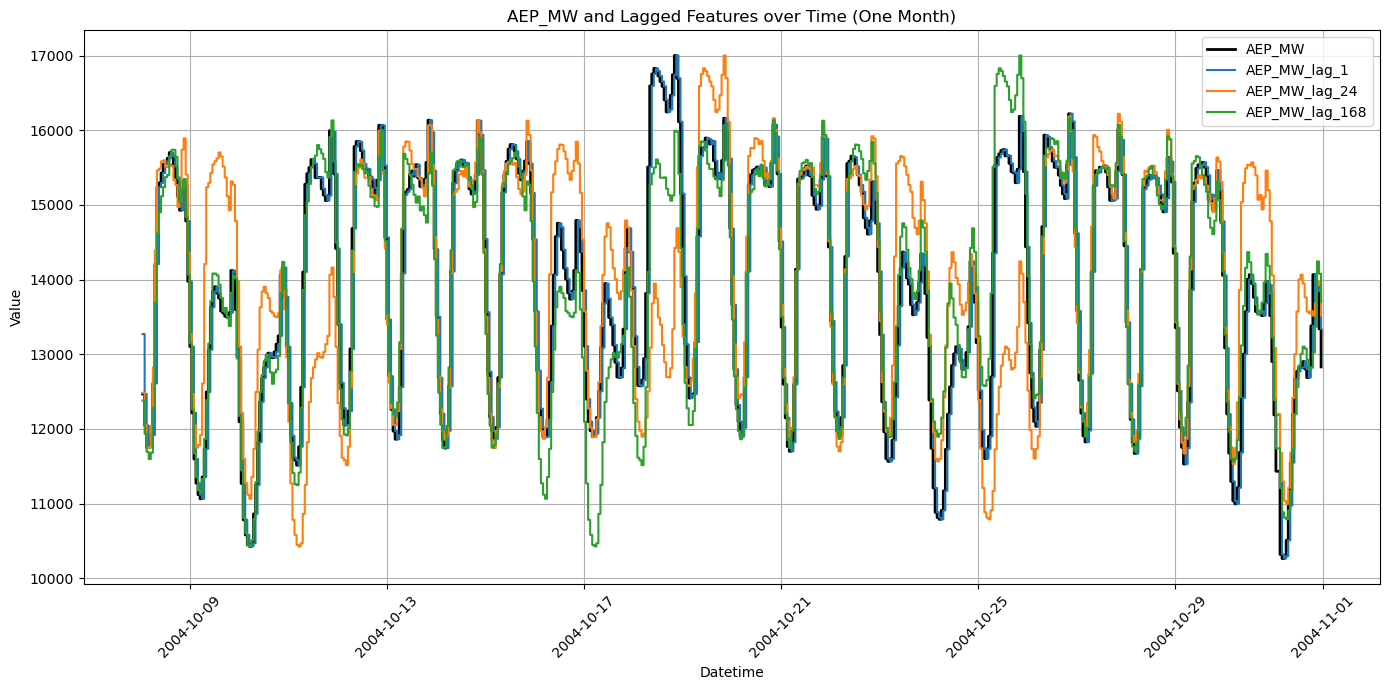

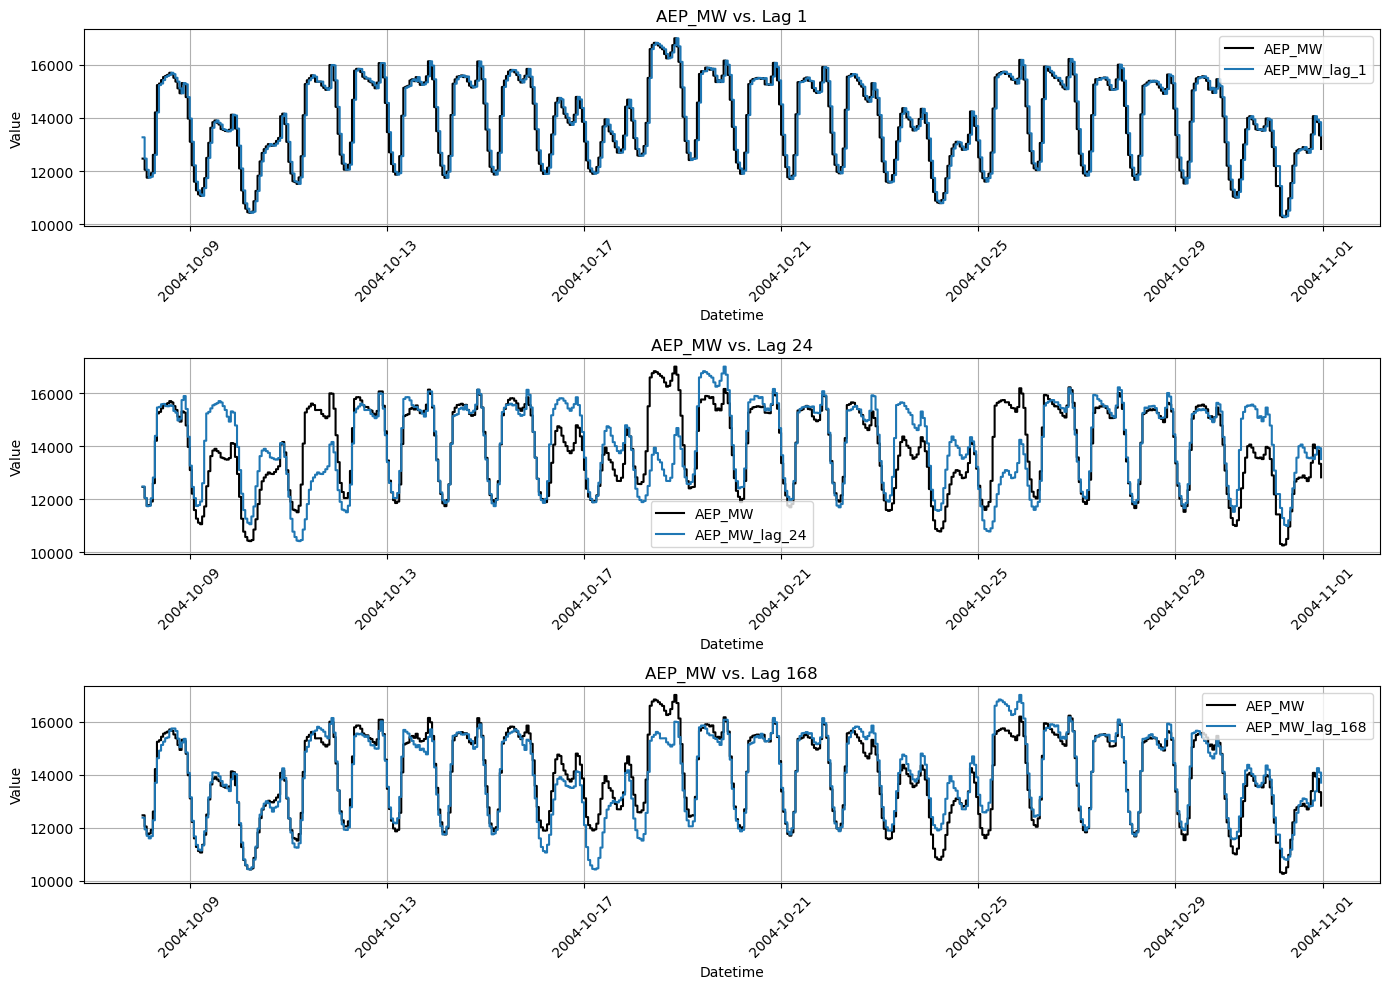

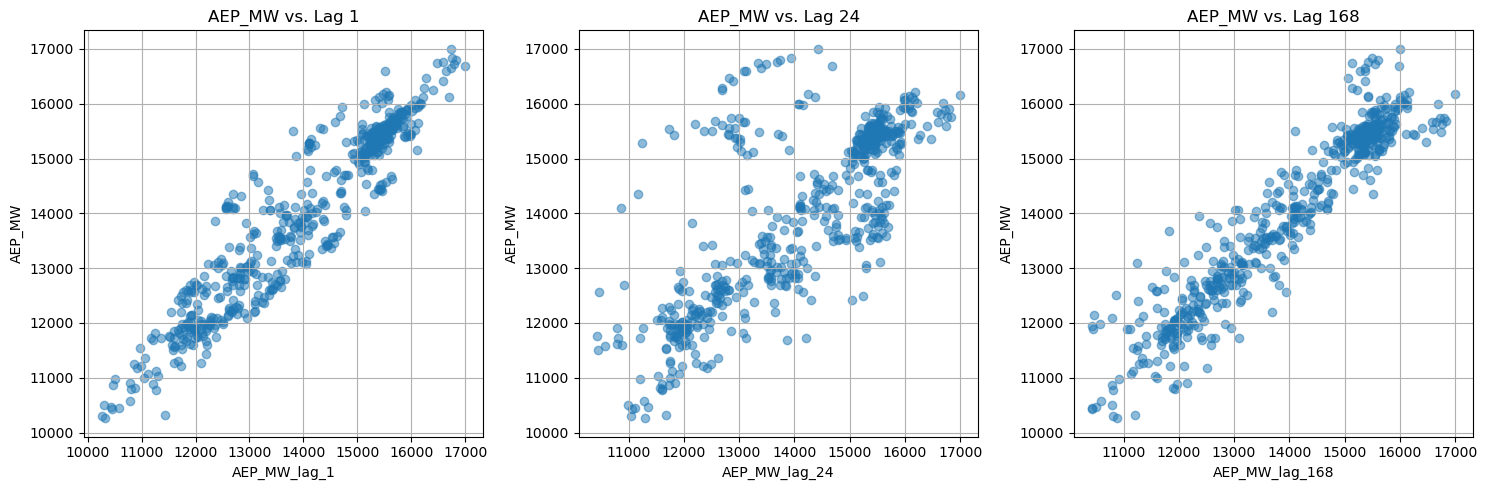

In [35]:
# Select the first month of data.
earliest_date = df['Datetime'].min()
subset = df[df['Datetime'].dt.year == earliest_date.year]
subset = subset[subset['Datetime'].dt.month == earliest_date.month]
subset = subset.reset_index(drop=True)
subset = subset.sort_values(by='Datetime')

# --- Single Plot (Improved Clarity) - Using Step Plots ---
plt.figure(figsize=(14, 7))

# Use plt.plot with drawstyle='steps-post'
plt.plot(subset['Datetime'], subset['AEP_MW'], label='AEP_MW', color='black', linewidth=2, drawstyle='steps-post')
plt.plot(subset['Datetime'], subset['AEP_MW_lag_1'], label='AEP_MW_lag_1', linestyle='-', drawstyle='steps-post') #Changed linestyle
plt.plot(subset['Datetime'], subset['AEP_MW_lag_24'], label='AEP_MW_lag_24', linestyle='-', drawstyle='steps-post')#Changed linestyle
plt.plot(subset['Datetime'], subset['AEP_MW_lag_168'], label='AEP_MW_lag_168', linestyle='-', drawstyle='steps-post')#Changed linestyle

plt.title('AEP_MW and Lagged Features over Time (One Month)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Subplots (Optional) - Also Using Step Plots ---
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(subset['Datetime'], subset['AEP_MW'], label='AEP_MW', color='black', drawstyle='steps-post')
plt.plot(subset['Datetime'], subset['AEP_MW_lag_1'], label='AEP_MW_lag_1', drawstyle='steps-post')
plt.title('AEP_MW vs. Lag 1')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(subset['Datetime'], subset['AEP_MW'], label='AEP_MW', color='black', drawstyle='steps-post')
plt.plot(subset['Datetime'], subset['AEP_MW_lag_24'], label='AEP_MW_lag_24', drawstyle='steps-post')
plt.title('AEP_MW vs. Lag 24')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(subset['Datetime'], subset['AEP_MW'], label='AEP_MW', color='black', drawstyle='steps-post')
plt.plot(subset['Datetime'], subset['AEP_MW_lag_168'], label='AEP_MW_lag_168', drawstyle='steps-post')
plt.title('AEP_MW vs. Lag 168')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --- Scatter plot
lags_to_plot = [1, 24, 168]
plt.figure(figsize=(15, 5))
for i, lag in enumerate(lags_to_plot):
    plt.subplot(1, len(lags_to_plot), i+1)
    plt.scatter(subset[f'AEP_MW_lag_{lag}'], subset['AEP_MW'], alpha=0.5)
    plt.title(f'AEP_MW vs. Lag {lag}')
    plt.xlabel(f'AEP_MW_lag_{lag}')
    plt.ylabel('AEP_MW')
    plt.grid(True)
plt.tight_layout()
plt.show()

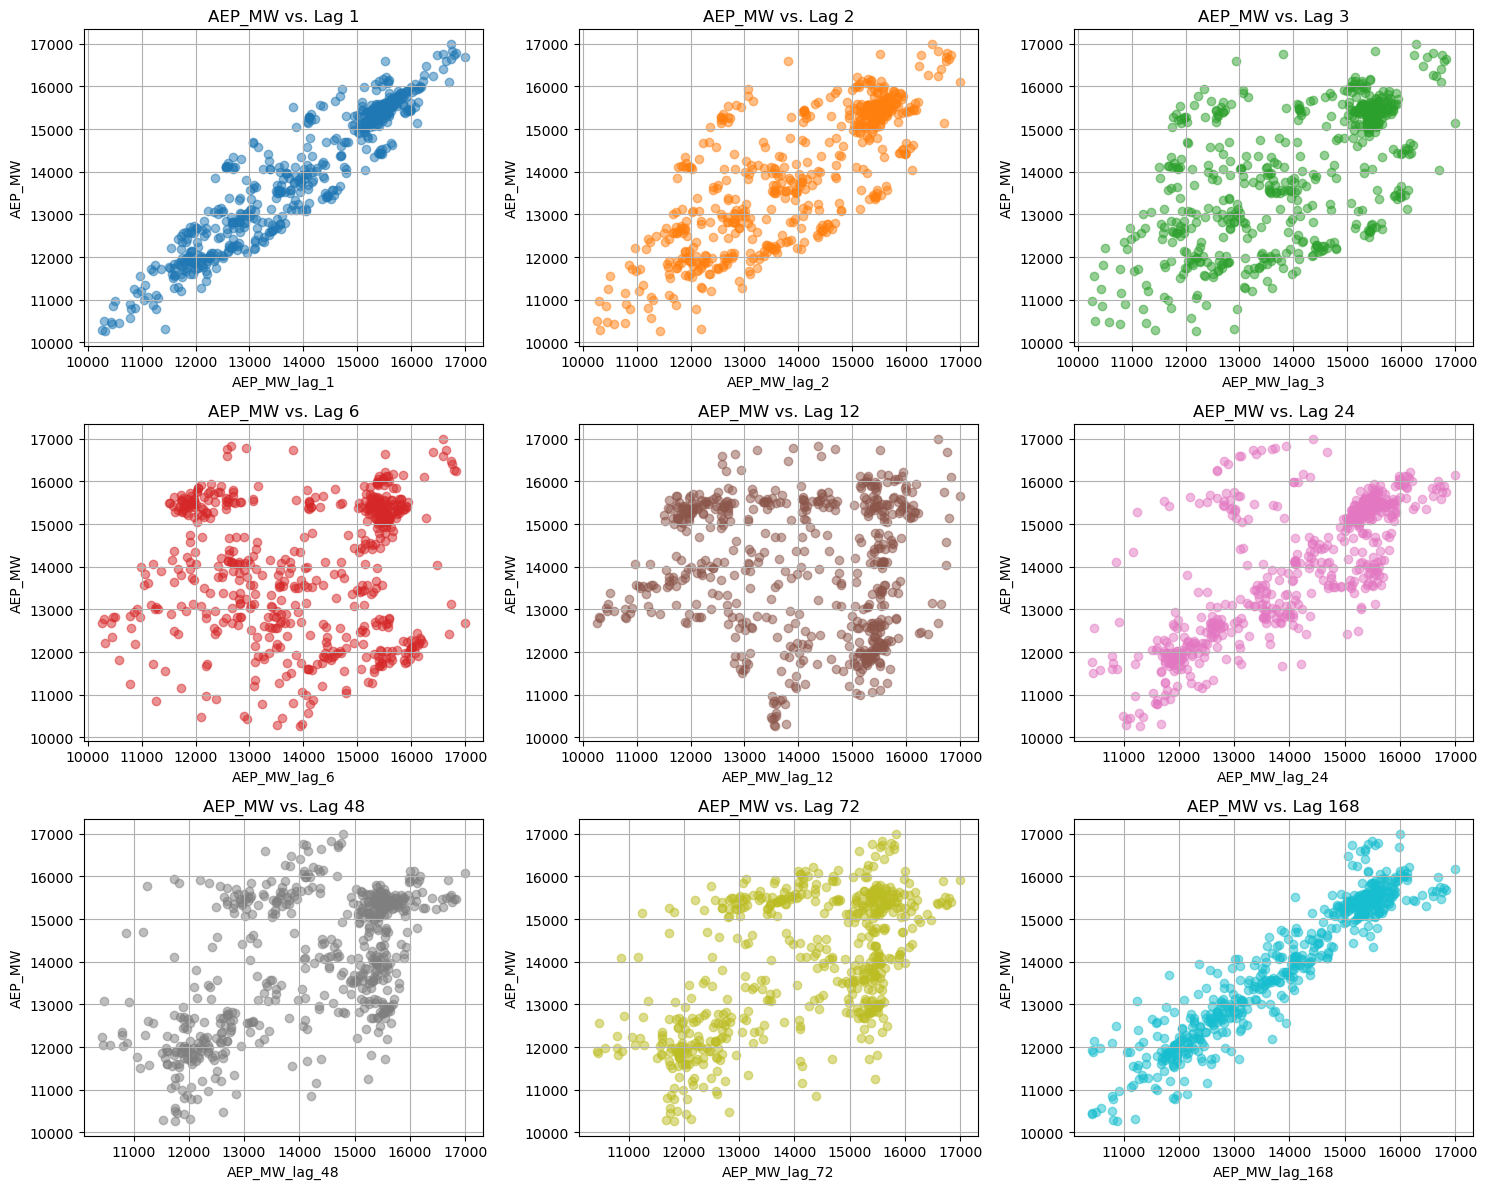

In [39]:
# Define lags and grid size
lags_to_plot = [1, 2, 3, 6, 12, 24, 48, 72, 168]
rows, cols = 3, 3  # 3x3 grid
colors = plt.cm.tab10(np.linspace(0, 1, len(lags_to_plot)))  # Assign unique colors

plt.figure(figsize=(15, 12))

for i, (lag, color) in enumerate(zip(lags_to_plot, colors)):
    plt.subplot(rows, cols, i+1)
    
    # Color based on lag
    plt.scatter(subset[f'AEP_MW_lag_{lag}'], subset['AEP_MW'], alpha=0.5, label=f'Lag {lag}', color=color)
    
    plt.title(f'AEP_MW vs. Lag {lag}')
    plt.xlabel(f'AEP_MW_lag_{lag}')
    plt.ylabel('AEP_MW')
    plt.grid(True)
    # plt.legend()  # Add legend to distinguish lags

plt.tight_layout()
plt.show()


## Export Data

In [37]:
print(PATH)

/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project


In [38]:
# Save the preprocessed data
df.to_csv(f'{PATH}/dataset/AEP_hourly_preprocessed.csv', index=False)